In [53]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk joblib lightgbm imbalanced-learn
!python -m nltk.downloader stopwords wordnet punkt

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from collections import Counter
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD

import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer



In [61]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

STOPWORDS = set(stopwords.words('english'))
PS = PorterStemmer()
LEMM = WordNetLemmatizer()

df = pd.read_csv('spam.csv')
df.columns=['label','text']
df = df.dropna().reset_index(drop=True)
df['label_num'] = df['label'].map({'ham':0,'spam':1})
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prakh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [64]:
print(df['label'].value_counts())
print(df['text'].apply(len).describe())
print(df['text'].apply(lambda x: len(x.split())).describe())

label
ham     4825
spam     747
Name: count, dtype: int64
count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: text, dtype: float64
count    5572.000000
mean       15.584171
std        11.406598
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: text, dtype: float64


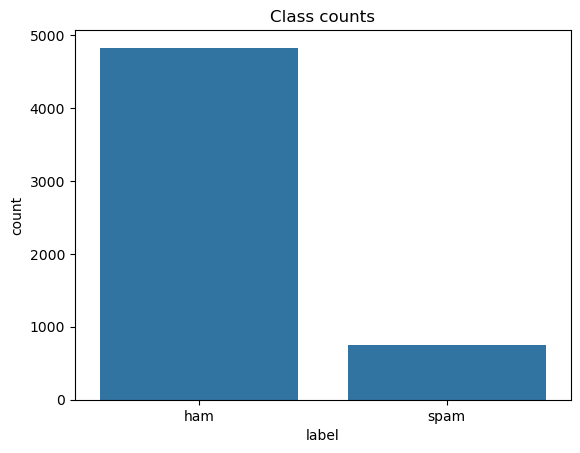

In [65]:
# Class Balance Visualization
sns.countplot(x='label', data=df)
plt.title('Class counts')
plt.show()

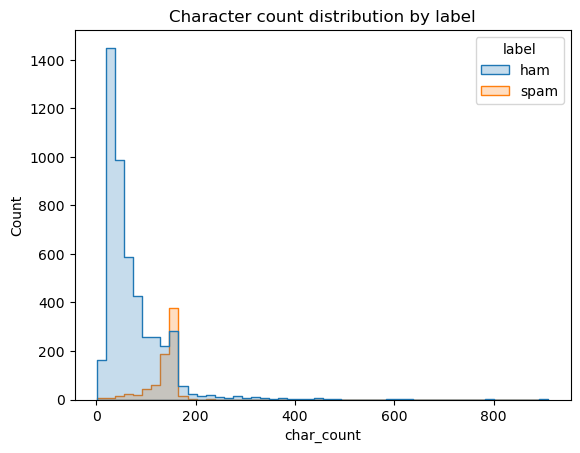

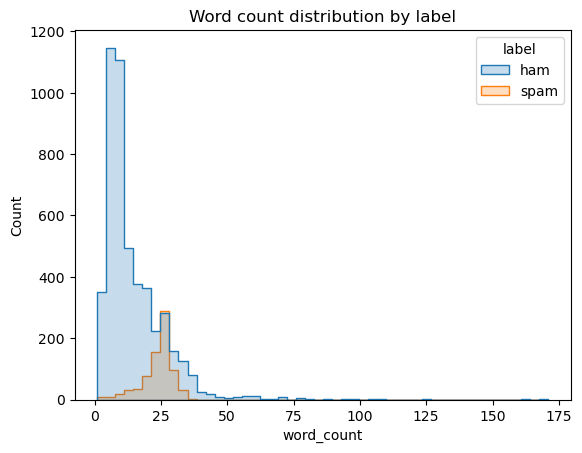

In [72]:
# Message Length Distribution Visualization
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)

sns.histplot(data=df, x='char_count', hue='label', bins=50, element='step')
plt.title('Character count distribution by label')
plt.show()

sns.histplot(data=df, x='word_count', hue='label', bins=50, element='step')
plt.title('Word count distribution by label')
plt.show()

In [73]:
# Top Words in each Class
def simple_tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

spam_text = ' '.join(df[df['label']=='spam']['text'].astype(str))
ham_text = ' '.join(df[df['label']=='ham']['text'].astype(str))

spam_counts = Counter(simple_tokenize(spam_text))
ham_counts = Counter(simple_tokenize(ham_text))

print('Top spam words:', spam_counts.most_common(20))
print('Top ham words:', ham_counts.most_common(20))

Top spam words: [('to', 688), ('a', 380), ('call', 352), ('you', 297), ('your', 264), ('free', 224), ('2', 207), ('for', 204), ('the', 203), ('now', 199), ('or', 188), ('u', 170), ('txt', 163), ('is', 157), ('on', 145), ('ur', 144), ('4', 137), ('have', 132), ('from', 131), ('mobile', 127)]
Top ham words: [('i', 2960), ('you', 1948), ('to', 1562), ('the', 1133), ('a', 1070), ('u', 1033), ('and', 858), ('in', 823), ('me', 777), ('my', 754), ('is', 739), ('it', 718), ('that', 560), ('of', 526), ('for', 507), ('s', 490), ('have', 443), ('can', 441), ('but', 441), ('so', 436)]


Text(0.5, 1.0, 'Word Count KDE')

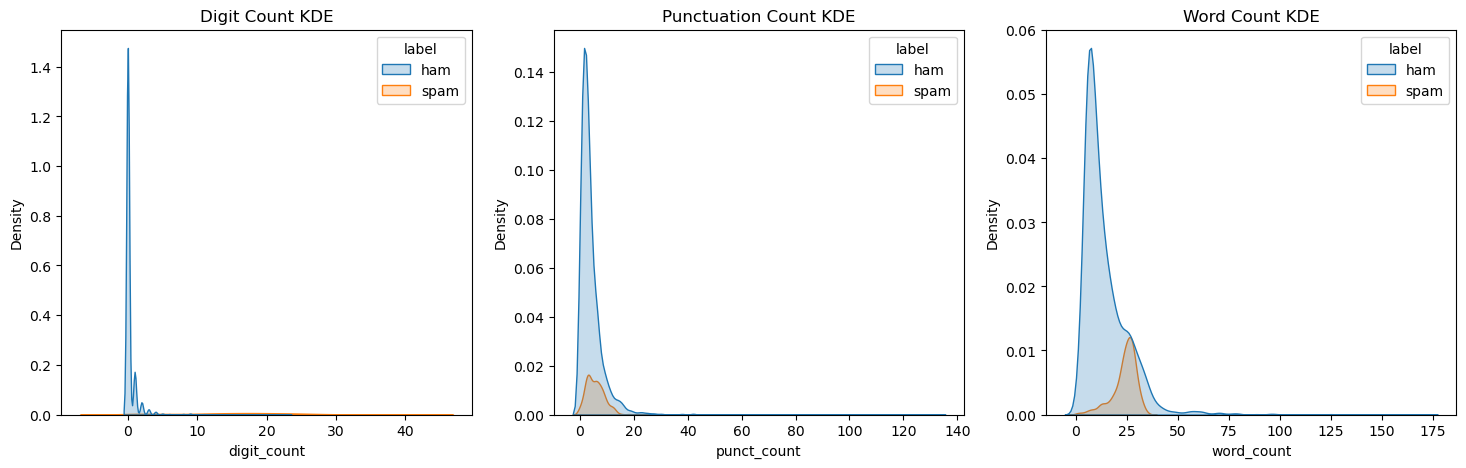

In [82]:
# Punctuation / digit / Uppercase Analysis
import string

def count_digits(s):
    return sum(c.isdigit() for c in s)

def count_punct(s):
    return sum(1 for c in s if c in string.punctuation)

def count_upper_words(s):
    return sum(1 for w in s.split() if w.isupper())

df['digit_count'] = df['text'].apply(count_digits)
df['punct_count'] = df['text'].apply(count_punct)
[df['digit_count'].describe(), df['punct_count'].describe()]

#visualisation
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(data=df, x='digit_count', hue='label', fill=True, ax=ax[0])
ax[0].set_title("Digit Count KDE")

sns.kdeplot(data=df, x='punct_count', hue='label', fill=True, ax=ax[1])
ax[1].set_title("Punctuation Count KDE")

sns.kdeplot(data=df, x='word_count', hue='label', fill=True, ax=ax[2])
ax[2].set_title("Word Count KDE")

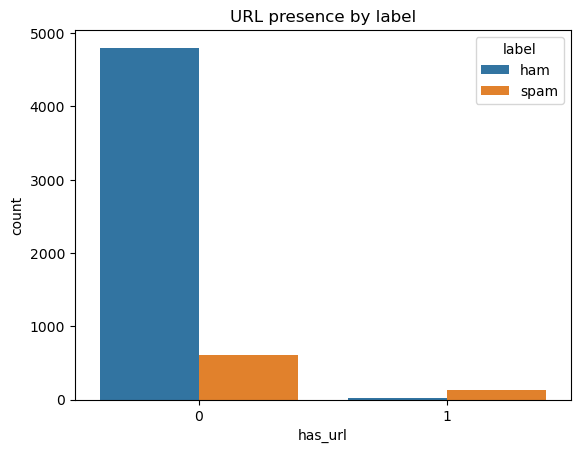

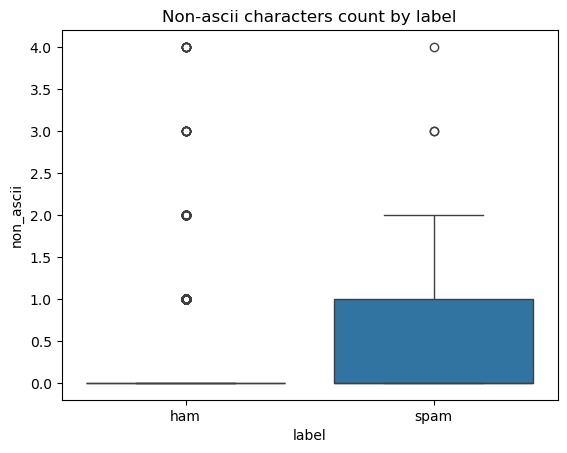

In [86]:
# URL presence & Non-ASCII chars
df['has_url'] = df['text'].str.contains('http|www|\.com|\.co', case=False, regex=True).astype(int)
df['non_ascii'] = df['text'].apply(lambda x: sum(1 for ch in x if ord(ch) > 127))

sns.countplot(x='has_url', hue='label', data=df)
plt.title('URL presence by label')
plt.show()

sns.boxplot(x='label', y='non_ascii', data=df)
plt.title('Non-ascii characters count by label')
plt.show()

In [89]:
# Text Cleaning / Preprocessing
STOPWORDS = set(stopwords.words("english"))
PS = PorterStemmer()
def clean_text(text, remove_stopwords=True, do_stem=False, keep_numbers=True):
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove numbers if not needed
    if not keep_numbers:
        text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = text.strip()
    # Split safely
    tokens = text.split() if text != "" else []
    # Remove stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    # Apply stemming
    if do_stem:
        tokens = [PS.stem(t) for t in tokens]
    return ' '.join(tokens)

# create cleaned column
df['clean_text'] = df['text'].apply(lambda x: clean_text(x, remove_stopwords=True, do_stem=False, keep_numbers=True))

# quick check
df[['text','clean_text']].head(8)

,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling 3 weeks word back id like ...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...


In [90]:
# Basic length Feature
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0)


# 4.2 counts we've computed earlier
# df['digit_count'], df['punct_count'], df['has_url'], df['non_ascii'] are already available


# 4.3 uppercase ratio
nd = df.copy()
nd['upper_count'] = nd['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
nd['upper_ratio'] = nd['upper_count'] / (nd['word_count'] + 1e-9)


# 4.4 promo keyword counts (user-defined)
promo_words = set(['free','win','winner','prize','cash','urgent','claim','offer','selected','congrat'])
nd['promo_cnt'] = nd['clean_text'].apply(lambda x: sum(1 for w in x.split() if w in promo_words))


# 4.5 unique token ratio / lexical diversity
nd['unique_word_ratio'] = nd['clean_text'].apply(lambda x: len(set(x.split()))/ (len(x.split())+1e-9))


# combine engineered features into a DF for later use
engineered_cols = ['char_count','word_count','avg_word_len','digit_count','punct_count','has_url','non_ascii','upper_ratio','promo_cnt','unique_word_ratio']
X_num = nd[engineered_cols].fillna(0)
X_num.head()

,char_count,word_count,avg_word_len,digit_count,punct_count,has_url,non_ascii,upper_ratio,promo_cnt,unique_word_ratio
0,111,20,4.600000,0,9,0,0,0.000000,0,1.000000
1,29,6,4.000000,0,6,0,0,0.000000,0,1.000000
2,155,28,4.571429,25,6,0,0,0.071429,2,0.913043
3,49,11,3.545455,0,6,0,0,0.181818,0,0.777778
4,61,13,3.769231,0,2,0,0,0.076923,0,1.000000


In [95]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_tfidf = tfidf.fit_transform(nd['clean_text'])
print('TF-IDF shape:', X_tfidf.shape)

# dimensionality reduction
svd = TruncatedSVD(n_components=300, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)
print('Reduced shape:', X_tfidf_reduced.shape)

TF-IDF shape: (5572, 5000)
Reduced shape: (5572, 300)


In [104]:
# Test-Train split
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 4457
Test size: 1115


In [106]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

In [108]:
# Defining Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "KNN (5 neighbors)": KNeighborsClassifier(n_neighbors=5)
}


In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
import pandas as pd

results = []

for name, model in models.items():
    pipe = Pipeline([
        ('tfidf', tfidf),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds)
    })
    print(f"\n===== {name} =====")
    print(classification_report(y_test, preds))


===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.97      0.96      1115


===== Linear SVM =====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96   

In [110]:
results_df = pd.DataFrame(results)
results_df.sort_values("f1", ascending=False)

,model,accuracy,precision,recall,f1
2,Linear SVM,0.982960,0.964286,0.906040,0.934256
3,Random Forest,0.977578,1.000000,0.832215,0.908425
0,Naive Bayes,0.966816,1.000000,0.751678,0.858238
1,Logistic Regression,0.965022,1.000000,0.738255,0.849421
4,KNN (5 neighbors),0.913004,1.000000,0.348993,0.517413


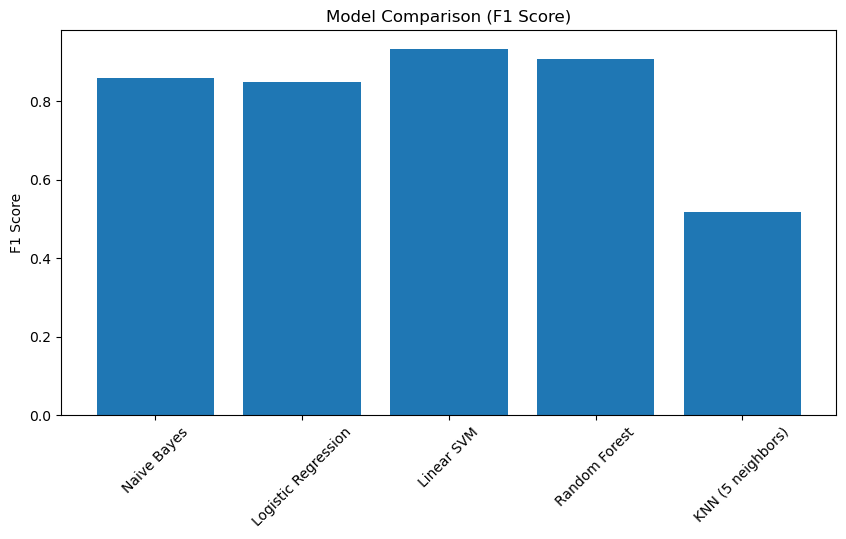

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(results_df["model"], results_df["f1"])
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1 Score)")
plt.xticks(rotation=45)
plt.show()

In [112]:
best_model_name = results_df.sort_values("f1", ascending=False).iloc[0]["model"]
best_model_name

'Linear SVM'

In [114]:
import pickle

best_model = models[best_model_name]

best_pipeline = Pipeline([
    ("tfidf", tfidf),
    ("model", best_model)
])

best_pipeline.fit(X_train, y_train)

with open("spam_classifier_pipeline.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print(f"Saved best model (with TF-IDF): {best_model_name}")

Saved best model (with TF-IDF): Linear SVM


In [115]:
final_preds = best_pipeline.predict(X_test)
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

